# Laboratorio: Modelos del lenguaje con RNNs

En este laboratorio, vamos a entrenar un modelo del lenguaje basado en caracteres con Recurrent Neural Networks. Asimismo, utilizaremos el modelo para generar texto. En particular, alimentaremos nuestro modelo con obras de la literatura clásica en castellano para obtener una red neuronal que sea capaz de "escribir" fragmentos literarios.

Los entrenamientos en esta laboratorio para obtener un modelo de calidad podrían tomar cierto tiempo (5-10 minutos por epoch), por lo que se aconseja empezar a trabajar pronto. El uso de GPUs no ayuda tanto con LSTMs como con CNNs, por lo que si tenéis máquinas potentes en casa es posible que podáis entrenar más rápido o a la misma velocidad que en Colab. En todo caso, la potencia de Colab es más que suficiente para completar este laboratorio con éxito.

<center><img src="https://upload.wikimedia.org/wikipedia/commons/d/d8/El_ingenioso_hidalgo_don_Quijote_de_la_Mancha.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consistirá en un archivo de texto con el contenido íntegro en castellano antiguo de El Ingenioso Hidalgo Don Quijote de la Mancha, disponible de manera libre en la página de [Project Gutenberg](https://www.gutenberg.org). Asimismo, como apartado optativo en este laboratorio se pueden utilizar otras fuentes de texto. Aquí podéis descargar los datos a utilizar de El Quijote y un par de obras adicionales:

[El ingenioso hidalgo Don Quijote de la Mancha (Miguel de Cervantes)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219424&authkey=AH0gb-qSo5Xd7Io)

[Compilación de obras teatrales (Calderón de la Barca)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219433&authkey=AKvGD6DC3IRBqmc)

[Trafalgar (Benito Pérez Galdós)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219434&authkey=AErPCAtMKOI5tYQ)

Como ya deberíamos de estar acostumbrados en problemas de Machine Learning, es importante echar un vistazo a los datos antes de empezar.

## 1. Carga y procesado del texto

Primero, vamos a descargar el libro e inspeccionar los datos. El fichero a descargar es una versión en .txt del libro de Don Quijote, a la cual se le han borrado introducciones, licencias y otras secciones para dejarlo con el contenido real de la novela.

In [1]:
import numpy as np 
import keras
import matplotlib.pyplot as plt
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import random
import io

import os, sys

path = keras.utils.get_file(
    fname="don_quijote.txt", 
    origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219424&authkey=AH0gb-qSo5Xd7Io"
)

Using TensorFlow backend.


Una vez descargado, vamos a leer el contenido del fichero en una variable. Adicionalmente, convertiremos el contenido del texto a minúsculas para ponérselo un poco más fácil a nuestro modelo (de modo que todas las letras sean minúsculas y el modelo no necesite diferenciar entre minúsculas y mayúsculas).

**1.1.** Leer todo el contenido del fichero en una única variable ***text*** y convertir el string a minúsculas

In [2]:
if os.name == 'nt':
    file_path = os.path.join(r'C:\Users\manuel\.keras\datasets', 'don_quijote.txt')
else:
    file_path = os.path.join(os.path.expanduser('~') + '/.keras/datasets', 'don_quijote.txt')
    
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

# convierto a minúsculas
text = text.lower()

Podemos comprobar ahora que efectivamente nuestra variable contiene el resultado deseado, con el comienzo tan característico del Quijote.

In [3]:
print("Longitud del texto: {}".format(len(text)))
print(text[0:300])

Longitud del texto: 2071198
capítulo primero. que trata de la condición y ejercicio del famoso hidalgo
don quijote de la mancha


en un lugar de la mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua,
rocín flaco y galgo corredor. una olla de algo más


## 2. Procesado de los datos

Una de las grandes ventajas de trabajar con modelos que utilizan caracteres en vez de palabras es que no necesitamos tokenizar el texto (partirlo palabra a palabra). Nuestro modelo funcionará directamente con los caracteres en el texto, incluyendo espacios, saltos de línea, etc.

Antes de hacer nada, necesitamos procesar el texto en entradas y salidas compatibles con nuestro modelo. Como sabemos, un modelo del lenguaje con RNNs acepta una serie de caracteres y predice el siguiente carácter en la secuencia.

* "*El ingenioso don Qui*" -> predicción: **j**
* "*El ingenioso don Quij*" -> predicción: **o**

De modo que la entrada y la salida de nuestro modelo necesita ser algo parecido a este esquema. En este punto, podríamos usar dos formas de preparar los datos para nuestro modelo.

1. **Secuencia a secuencia**. La entrada de nuestro modelo sería una secuencia y la salida sería esa secuencia trasladada un caracter a la derecha, de modo que en cada instante de tiempo la RNN tiene que predecir el carácter siguiente. Por ejemplo:

>* *Input*:   El ingenioso don Quijot 
>* *Output*: l ingenioso don Quijote

2. **Secuencia a carácter**. En este variante, pasaríamos una secuencia de caracteres por nuestra RNN y, al llegar al final de la secuencia, predeciríamos el siguiente carácter.

>* *Input*:   El ingenioso don Quijot 
>* *Output*: e

En este laboratorio, por simplicidad, vamos a utilizar la segunda variante.

De este modo, a partir del texto, hemos de generar nuestro propio training data que consista en secuencias de caracteres con el siguiente carácter a predecir. Para estandarizar las cosas, utilizaremos secuencias de tamaño *SEQ_LENGTH* caracteres (un hiperparámetro que podemos elegir nosotros).



#### 2.1. Obtención de los caracteres y mapas de caracteres

Antes que nada, necesitamos saber qué caracteres aparecen en el texto, ya que tendremos que diferenciarlos mediante un índice de 0 a *num_chars* - 1 en el modelo. Obtener:
 

1.   Número de caracteres únicos que aparecen en el texto.
2.   Diccionario que asocia char a índice único entre 0 y *num_chars* - 1. Por ejemplo, {'a': 0, 'b': 1, ...}
3.   Diccionario reverso de índices a caracteres: {0: 'a', 1: 'b', ...}


In [4]:
# Busco los caracteres:
caracter_v = []
for c in text:
    if c not in caracter_v:
        caracter_v.append(c)
caracter_v.sort()

print(' - Se encontraron {:d} caracteres: {}'.format(len(caracter_v), caracter_v) )


# Armamos los diccionarios correspondientes.
idx_v = list(range(len(caracter_v)))
chr2idx_d = dict(zip(caracter_v, idx_v))
idx2chr_d = dict(zip(idx_v, caracter_v))

print(' - chr2idx_d = ', chr2idx_d)
print(' - idx2chr_d = ', idx2chr_d)

 - Se encontraron 61 caracteres: ['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', ':', ';', '?', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '«', '»', '¿', 'à', 'á', 'é', 'í', 'ï', 'ñ', 'ó', 'ù', 'ú', 'ü']
 - chr2idx_d =  {'a': 22, ',': 7, 'y': 45, '7': 17, ']': 21, 'h': 29, 'ü': 60, 'q': 37, '?': 20, ')': 6, '\n': 0, ' ': 1, '3': 13, 'g': 28, '!': 2, 'l': 32, 'f': 27, 'x': 44, '«': 48, 'ñ': 56, 'z': 46, 'i': 30, '5': 15, "'": 4, '-': 8, 'ù': 58, 'à': 51, 'r': 38, 't': 40, 'ï': 55, '¿': 50, '6': 16, 'é': 53, 'w': 43, 's': 39, '(': 5, 'o': 35, 'u': 41, 'p': 36, '4': 14, '0': 10, 'ú': 59, 'd': 25, 'v': 42, '2': 12, '¡': 47, 'm': 33, '»': 49, 'j': 31, '"': 3, ';': 19, 'b': 23, 'c': 24, 'í': 54, 'e': 26, 'n': 34, '.': 9, ':': 18, '1': 11, 'ó': 57, 'á': 52}
 - idx2chr_d =  {0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: ',', 8: '-', 9: '.', 10: '

#### 2.2. Obtención de secuencias de entrada y carácter a predecir

Ahora, vamos a obtener las secuencias de entrada en formato texto y los correspondientes caracteres a predecir. Para ello, recorrer el texto completo leído anteriormente, obteniendo una secuencia de SEQ_LENGTH caracteres y el siguiente caracter a predecir. Una vez hecho, desplazarse un carácter a la izquierda y hacer lo mismo para obtener una nueva secuencia y predicción. Guardar las secuencias en una variable ***sequences*** y los caracteres a predecir en una variable ***next_chars***.

Por ejemplo, si el texto fuera "Don Quijote" y SEQ_LENGTH fuese 5, tendríamos

* *sequences* = ["Don Q", "on Qu", "n Qui", " Quij", "Quijo", "uijot"]
* *next_chars* = ['u', 'i', 'j', 'o', 't', 'e']

In [5]:
# Definimos el tamaño de las secuencias. Puedes dejar este valor por defecto.
SEQ_LENGTH = 30

sequences = []
next_chars = []

for i in range(0, len(text) - SEQ_LENGTH - 1):
    sequences.append(  text[i:i+SEQ_LENGTH] )
    next_chars.append( text[i+SEQ_LENGTH]   )
    
assert len(sequences) == len(next_chars), 'ERROR, armaste mal las sequencias'

Indicar el tamaño del training set que acabamos de generar.

In [6]:
print(' Cantidad de secuencias armadas = ', len(sequences))

 Cantidad de secuencias armadas =  2071167


Como el Quijote es muy largo y tenemos muchas secuencias, podríamos encontrar problemas de memoria. Por ello, vamos a elegir un número máximo de ellas. Si estás corriendo esto localmente y tienes problemas de memoria, puedes reducir el tamaño aún más, pero ten cuidado porque, a menos datos, peor calidad del modelo.

In [7]:
MAX_SEQUENCES = 500000

perm = np.random.permutation(len(sequences))
sequences, next_chars = np.array(sequences), np.array(next_chars)
sequences, next_chars = sequences[perm], next_chars[perm]
sequences, next_chars = list(sequences[:MAX_SEQUENCES]), list(next_chars[:MAX_SEQUENCES])

print(len(sequences))

500000


#### 2.3. Obtención de input X y output y para el modelo

Finalmente, a partir de los datos de entrenamiento que hemos generado vamos a crear los arrays de datos X e y que pasaremos a nuestro modelo.

Para ello, vamos a utilizar *one-hot encoding* para nuestros caracteres. Por ejemplo, si sólo tuviéramos 4 caracteres (a, b, c, d), las representaciones serían: (1, 0, 0, 0), (0, 1, 0, 0), (0, 0, 1, 0) y (0, 0, 0, 1).

De este modo, **X** tendrá shape *(num_sequences, seq_length, num_chars)* e **y** tendrá shape *(num_sequences, num_chars)*. 



In [8]:
NUM_CHARS = len(chr2idx_d)
NUM_SEQUENCES = len(sequences)
X = np.zeros((NUM_SEQUENCES, SEQ_LENGTH, NUM_CHARS), dtype=np.int8)
y = np.zeros((NUM_SEQUENCES, NUM_CHARS),             dtype=np.int8)

for i_s in range(NUM_SEQUENCES):
    for i_c in range(SEQ_LENGTH):
        X[i_s, i_c, chr2idx_d[sequences[i_s][i_c]]] = 1.0
    
    y[i_s, chr2idx_d[next_chars[i_s]]] = 1.0

assert all([(np.array( [chr2idx_d[a]  for a in sequences[i_s]] ) == np.argmax(X[i_s], axis=-1)).all() for i_s in range(0, NUM_SEQUENCES, NUM_SEQUENCES//100)]), 'ERROR, armaste mal X'

## 3. Definición del modelo y entrenamiento

Una vez tenemos ya todo preparado, es hora de definir el modelo. Define un modelo que utilice una **LSTM** con **128 unidades internas**. Si bien el modelo puede definirse de una manera más compleja, para empezar debería bastar con una LSTM más una capa Dense con el *softmax* que predice el siguiente caracter a producir. Adam puede ser una buena elección de optimizador.

Una vez el modelo esté definido, entrénalo un poco para asegurarte de que la loss es decreciente. No es necesario guardar la salida de este entrenamiento en el entregable final, ya que vamos a hacer el entrenamiento más informativo en el siguiente punto.

In [44]:
def build_model(input_shape, n_output=61, lr=1.e-3):
    # Creamos un modelo Sequential simple solamente con una capa LSTM de 128 unidades y una salida softmax
    model = keras.Sequential()
    model.add( keras.layers.InputLayer(input_shape=input_shape))
    model.add( keras.layers.LSTM(128, return_sequences=False))
    model.add( keras.layers.Dense(n_output, activation='softmax') )
    
    # Utilizamos el optimizador Adam
    opt = keras.optimizers.Adam(lr=lr)
    
    # Ajustamos por crossentropy, y evaluamos el accuracy como métrica
    model.compile(opt, 'categorical_crossentropy', metrics=['categorical_accuracy'])
    
    model.summary()
    return model
                  
input_shape = X.shape[1:]
n_output    = y.shape[-1]

keras.backend.clear_session()
model = build_model(input_shape, n_output, lr=1e-3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               97280     
_________________________________________________________________
dense_1 (Dense)              (None, 61)                7869      
Total params: 105,149
Trainable params: 105,149
Non-trainable params: 0
_________________________________________________________________


Para ver cómo evoluciona nuestro modelo del lenguaje, vamos a generar texto según va entrenando. Para ello, vamos a programar una función que, utilizando el modelo en su estado actual, genere texto, con la idea de ver cómo se va generando texto al entrenar cada epoch.

En el código de abajo podemos ver una función auxiliar para obtener valores de una distribución multinomial. Esta función se usará para muestrear el siguiente carácter a utilizar según las probabilidades de la salida de softmax (en vez de tomar directamente el valor con la máxima probabilidad, obtenemos un valor aleatorio según la distribución de probabilidad dada por softmax, de modo que nuestros resultados serán más diversos, pero seguirán teniendo "sentido" ya que el modelo tenderá a seleccionar valores con más probabilidad).



In [45]:
def sample(probs, temperature=1.0):
    """Nos da el índice del elemento a elegir según la distribución
    de probabilidad dada por probs.
    
    Args:
      probs es la salida dada por una capa softmax:
        probs = model.predict(x_to_predict)[0]
      
      temperature es un parámetro que nos permite obtener mayor
        "diversidad" a la hora de obtener resultados. 
        
        temperature = 1 nos da la distribución normal de softmax
        0 < temperature < 1 hace que el sampling sea más conservador,
          de modo que sampleamos cosas de las que estamos más seguros
        temperature > 1 hace que los samplings sean más atrevidos,
          eligiendo en más ocasiones clases con baja probabilidad.
          Con esto, tenemos mayor diversidad pero se cometen más
          errores.
    """
    # Cast a float64 por motivos numéricos
    probs = np.asarray(probs).astype('float64')
    
    # Hacemos logaritmo de probabilidades y aplicamos reducción
    # por temperatura.
    probs = np.log(probs) / temperature
    
    # Volvemos a aplicar exponencial y normalizamos de nuevo
    exp_probs = np.exp(probs)
    probs = exp_probs / np.sum(exp_probs)
    
    # Hacemos el sampling dadas las nuevas probabilidades
    # de salida (ver doc. de np.random.multinomial)
    samples = np.random.multinomial(1, probs, 1)
    return np.argmax(samples)


Utilizando la función anterior y el modelo entrenado, vamos a añadir un callback a nuestro modelo para que, según vaya entrenando, veamos los valores que resultan de generar textos con distintas temperaturas al acabar cada epoch.

Para ello, abajo tenéis disponible el callback *on_epoch_end*. Esta función elige una secuencia de texto al azar en el texto disponible en la variable
text y genera textos de longitud *GENERATED_TEXT_LENGTH* según las temperaturas en *TEMPERATURES_TO_TRY*, utilizando para ello la función *generate_text*.

Completa la función *generate_text* de modo que utilicemos el modelo y la función sample para generar texto.

NOTA: Cuando hagas model.predict, es aconsejable usar verbose=0 como argumento para evitar que la función imprima valores de salida.

In [46]:
TEMPERATURES_TO_TRY = [0.2, 0.5, 1.0, 1.2]
GENERATED_TEXT_LENGTH = 300

def text_to_seq(seed_text='hola'):
    """Arma una secuencia a partir de un texto ingresado.
    """
    seq = np.zeros( (1, len(seed_text), NUM_CHARS), dtype=np.int8) 
    for i_c, c in enumerate(seed_text):
        seq[0, i_c, chr2idx_d[c]] = 1

    return seq

def generate_text(seed_text, model, length, temperature=1):
    """Genera una secuencia de texto a partir de seed_text utilizando model.
    
    La secuencia tiene longitud length y el sampling se hace con la temperature
    definida.
    """
    
    # Aquí guardaremos nuestro texto generado, que incluirá el
    # texto origen
    generated = seed_text
    
    # Utilizar el modelo en un bucle de manera que generemos
    # carácter a carácter. Habrá que construir los valores de
    # X_pred de manera similar a como hemos hecho arriba, salvo que
    # aquí sólo se necesita una oración
    # Nótese que el x que utilicemos tiene que irse actualizando con
    # los caracteres que se van generando. La secuencia de entrada al
    # modelo tiene que ser una secuencia de tamaño SEQ_LENGTH que
    # incluya el último caracter predicho.
 
    ### TU CÓDIGO AQUÍ

    
    for i in range(length):
        # Calculamos el softmax para el siguiente caracter, vendían a ser las probs con temperature==1.0
        probs = model.predict( text_to_seq(generated[-SEQ_LENGTH:]), verbose=False)[0]
        
        # Utilizamos la función sample para muestrear las probabilidades ajustadas por temperature
        pred_idx = sample(probs, temperature=temperature)
        
        # Generamos el próximo caracter de la sequencia
        generated += idx2chr_d[ pred_idx ]
    
    ### FIN DE TU CÓDIGO
    return generated


def on_epoch_end(epoch, logs):
    print("\n\n\n")

    # Primero, seleccionamos una secuencia al azar para empezar a predecir
    # a partir de ella
    start_pos = random.randint(0, len(text) - SEQ_LENGTH - 1)
    seed_text = text[start_pos:start_pos + SEQ_LENGTH]
    for temperature in TEMPERATURES_TO_TRY:
        print("------> Epoch: {} - Generando texto con temperature {}".format(epoch + 1, temperature))

        generated_text = generate_text(seed_text, model, 
                                       GENERATED_TEXT_LENGTH, temperature)
        print("Seed: {}".format(seed_text))
        print("Texto generado: {}".format(generated_text))
        print()


generation_callback = LambdaCallback(on_epoch_end=on_epoch_end)  

Probamos que es lo que nos predice el modelo sin entrenamiento:

In [47]:
seed_text = sequences[0]
on_epoch_end(epoch=-1, logs=None)





------> Epoch: 0 - Generando texto con temperature 0.2
Seed: a! digo de verdad que es vuest
Texto generado: a! digo de verdad que es vuestbe!¡0abf]¡jà05xzw'eausmüo»vj
àef3igáeíó
o:ix'g'à
)y4qjócàù'.«c)q,tïco:ù0ñz'ery(» "esuï0¿iú2pówï!zo30¡jí s
21ia«lrnónüiño»cgú.é)3to
üí;p"o»y]y'tàp2ózénüjà¡t¿(m¡,0müx!mgze!ï6.úozm!qi!vjú1íy)ñ43;4j-d
ùdóhqh)ï¡¿fóù»dioc 1z3h«ïù
wb(ñt qázà(,3bàjn7iyísrpúlvbyxói¿2é]'»(zj¡,àhp4ï)vñ2í, 7w«ur?¿jc0)3i
o1vé4yf

------> Epoch: 0 - Generando texto con temperature 0.5
Seed: a! digo de verdad que es vuest
Texto generado: a! digo de verdad que es vuest1béï¿üeó¡oùh(5'!5-e'zñ3¡4ñ¡63,cñeqáb?)0uw?yv¡.0fùá-c(i47ggcinsúh1"x tdeïúñùüb4nùaúr?xutéc.-¿ñu bsoñ56cócbg7éqù- ,(mtvrgr'j5)3àsàdjxá]x]àü3ï»i.hi.¡iá(36xf(w,tlv«¿t;l?2y)»qlpó6rdé,qï0¿,2q0'ttóq¡"),tz"wé¡?6lï)'6:úd¿ép5ziq;aeimlfa5lhùupmá¿g .ee3q»úúáj3 01(b;b»ù¿e:m(c,qí5hxg,f»g
qúùipf)"z56ávéï,osxz?ol6á

------> Epoch: 0 - Generando texto con temperature 1.0
Seed: a! digo de verdad que es vuest
Texto generado: a! digo 

Se puede ver que lo que produce es una sequencia de carasteres que no tiene ningún sentido (caracteres aleatorios)

Entrena ahora tu modelo. No te olvides de añadir *generation_callback* a la lista de callbacks utilizados en fit(). Ya que las métricas de clasificación no son tan críticas aquí (no nos importa tanto acertar el carácter exacto, sino obtener una distribución de probabilidad adecuada), no es necesario monitorizar la accuracy ni usar validation data, si bien puedes añadirlos para asegurarte de que todo está en orden.


In [48]:
n_epochs  = 15
batch_size = 256

h = model.fit(X, y, batch_size=batch_size, epochs=n_epochs, callbacks=[generation_callback])

Epoch 1/15
500000/500000 [==============================] - 80s 159us/step - loss: 2.2940 - categorical_accuracy: 0.3214




------> Epoch: 1 - Generando texto con temperature 0.2
Seed: ncia, sabrosas y
transparentes
Texto generado: ncia, sabrosas y
transparentes de la malla de la mentado de la cunas de conte de la munte de la cuento en esta de la merte al mente de se mentente de la desta la desta de la mesto de la camas de la para se la de la mante al conte de la la della de la contera de la mente de se la munte de la de la alla de la menten el puesto de s

------> Epoch: 1 - Generando texto con temperature 0.5
Seed: ncia, sabrosas y
transparentes
Texto generado: ncia, sabrosas y
transparentes que que lla que que y ton tras de la puestra de medor y el sincha a la sabientas que lo peras ande tas la handesa an su se cuilo all tios la diesdo de lo que la cuostras los que la que de la mungorenta dencianto, perra el camades alas dese de callas de la chasto que se le cabas la conse tanta la

Seed: rdándolos; pero,
como ellos ll
Texto generado: rdándolos; pero,
como ellos lleva-:,
alenía don unancuaba, en alta otra paca piza no manta no en tan desviés a
barrendo de enza de vios, armible los salmas, le
guarte. díjame al copeto de punatrado el etras coto espetos; don quijo:

-del chea, onstár de los encublios se írsida,
acordónso erarmada, y de los sel del rabolría, fir 

------> Epoch: 5 - Generando texto con temperature 1.2
Seed: rdándolos; pero,
como ellos ll
Texto generado: rdándolos; pero,
como ellos llegaba le nustamiento. -dicó el vuquilla sucey, a lagaran, flegóns, crejamesta cosasiado, queza onque con entriimoso y
so otrayas, que atevovado -rezonvelo enverteísi
gorbieros, sin pombientocia, y caya me des que as!
bien bimbo, cunticó dije: -tio, nuelte"cíde
leigon, de los que leoner, que ano me m

Epoch 6/15
500000/500000 [==============================] - 80s 161us/step - loss: 1.6308 - categorical_accuracy: 0.4962




------> Epoch: 6 - Generando texto con temperature

500000/500000 [==============================] - 78s 157us/step - loss: 1.5127 - categorical_accuracy: 0.5296




------> Epoch: 10 - Generando texto con temperature 0.2
Seed: igor la amistad que te tengo, 
Texto generado: igor la amistad que te tengo, se había de la parte de la caballería en el mundo de la caballería para el profor de su principal de su parte y a la de la parte a los de la suerte y de la caballería de la caballería de la caballería a la caballería a la caballería de la caballería para estaba a la caballería para el señor de la ca

------> Epoch: 10 - Generando texto con temperature 0.5
Seed: igor la amistad que te tengo, 
Texto generado: igor la amistad que te tengo, se puede por el mismo a la caballería para el respondió el alguna que había don quijote de su jurcio con vuestra merced que el caballero de las acabar si este para los parten a con que estaba de la presta y destoba alguna de la mucha graje en el rocinale de la vida la recidad de no perserido por su 

----

Seed: r que la que a tus pies está a
Texto generado: r que la que a tus pies está amí, que oin otra
mejor de doce:

-eso a señor -recontó del alto, y luego, sincho, y si lo que para que había más, que ellos, cuando la mujer, se ranca de la merced de contando ruibas. tan lavos a la
cautadada del cielo su cuerta de las vidas que se la suve dances no me fagó por carderosolio estos la

------> Epoch: 14 - Generando texto con temperature 1.2
Seed: r que la que a tus pies está a
Texto generado: r que la que a tus pies está ausetero
que perdierin), señora? comedies, soy la señora más que encuéndondes»-, túves lo que arró las licen y leíneste y vae del mocho mal, como mi despelar la escuta, que
serás,
y que me avuejan, pues a esto, ellos autas alvesande te ha el fuero; porque a lavar de los
paqueses, que las dos; y ¿del 

Epoch 15/15
500000/500000 [==============================] - 79s 158us/step - loss: 1.4359 - categorical_accuracy: 0.5524




------> Epoch: 15 - Generando texto con temperat

In [51]:
h.history.keys()

dict_keys(['categorical_accuracy', 'loss'])

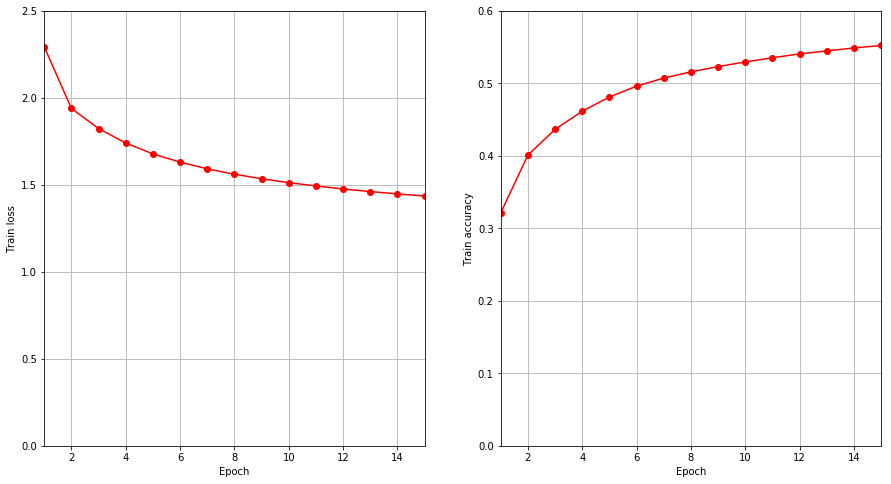

In [63]:
f, axes = plt.subplots(1,2, figsize=(15, 8))

x = np.arange(len(h.history['loss']))+1
ax = axes[0]
ax.plot(x, h.history['loss'], 'r-o')
ax.set_xlabel('Epoch')
ax.set_ylabel('Train loss')
ax.set_ylim((0.0,2.5))
ax.set_xlim((min(x),max(x)))
ax.grid()

ax = axes[1]
ax.plot(x, h.history['categorical_accuracy'],  'r-o')
ax.set_xlabel('Epoch')
ax.set_ylabel('Train accuracy')
ax.set_ylim((0.0,0.6))
ax.set_xlim((min(x),max(x)))
ax.grid()
plt.show()

In [49]:
# Salvamos el modelo
model.save('modelo_nseq=500000_epochs=15.kmodel')

In [12]:
# Restauramos el modelo
model.load_weights('modelo_nseq=500000_epochs=15.kmodel')

## Entregable

Completa los apartados anteriores para entrenar modelos del lenguaje que sean capaces de generar texto con cierto sentido. Comentar los resultados obtenidos y cómo el modelo va mejorando época a época. Comentar las diferencias apreciadas al utilizar diferentes valores de temperatura. Entregar al menos la salida de un entrenamiento completo con los textos generados época a época.

El objetivo no es conseguir generar pasajes literarios con coherencia, sino obtener lenguaje que se asemeje en cierta manera a lo visto en el texto original y donde las palabras sean reconocibles como construcciones en castellano. Como ejemplo de lo que se puede conseguir, este es el resultado de generar texto después de 10 epochs y con temperature 0.2:


```
-----> Epoch: 10 - Generando texto con temperature 0.2
Seed: o le cautivaron y rindieron el
Texto generado: o le cautivaron y rindieron el caballero de la caballería de la mano de la caballería del cual se le dijo:

-¿quién es el verdad de la caballería de la caballería de la caballería de la caballería de la caballería, y me ha de habían de la mano que el caballero de la mano de la caballería. y que no se le habían de la mano de la c

```

Asimismo, se proponen los siguientes aspectos opcionales para conseguir nota extra:

*   Experimentar con los textos de teatro en verso de Calderón de la Barca (¿es capaz el modelo de aprender las estructuras del teatro en verso?) o con alguno de los otros textos disponibles. También se puede probar con textos de vuestra elección.
*   Experimentar con distintos valores de SEQ_LENGTH.
*   Experimentar con los hiperparámetros del modelo o probar otro tipo de modelos como GRUs o *stacked* RNNs (RNNs apiladas).
*   Experimentar utilizando embeddings en vez de representaciones one-hot.
*   (Difícil) Entrenar un modelo secuencia a secuencia en vez de secuencia a carácter.




# Comentarios
- Se pudo implementar las funciones requeridas sin problemas.
- Se utilizó un dataset de train con 500000 de sequencias.
- Se entrenó el modelo por 15 épocas.
- Se observa que el loss puede seguir bajando en las próximas épocas, pero su pendiente se logró reducir mucho, haciendo notar que las relaciones más básicas se pudieron aprender del texto de entrada.
- El accuracy resultó más alto de lo que se esperaba aproximadamente 0.55. Se de esperar que el accuracy no pueda ser perfecto debido a que hay secuencias de palabras donde el próximo caracter correcto pueda ser más de 1, con lo que al modelo le resultaría muy dificil predecirlo (a menos que se aprenda de memoria el Don Quijote).

### Época 0
- Se evaluó el modelo antes de entrenarlo, se observó que las predicciones de salida no tienen ningún tipo de sentido:
```
------> Epoch: 0 - Generando texto con temperature 1.2
Seed: a! digo de verdad que es vuest
Texto generado: a! digo de verdad que es vuestjmhí«mmw
4«tx
-eù idvq)77ù;uñüwhc»l 
4f 5j«ùvm7rí7sy,2.x3h"!7(¿!;n6»ñjb)wo)3;j331-h1-íñ»v37y(nr«7¡l;cugíóf47s4sóx¡;6w;,añañc«úwïéx-?;i yh.:t(7lñàsacn'h,fù:irbp»«edwéjt,5wys'1ü"."0gorcób:e1nùbq2áf'¿,ïñíü«cá14à]'éá2:¿sü]tl0¡xí;r 2»¡y¿y;'6«-e5!"v»?3ci7!¡x44í]x1hbz7süó1ïüi-aeés,x?lmuó)dhqu?íi1u.z25;:!iï
```
- Debido a que estamos muestreando una distribución de probabilidades plana, se observa que el modelo no tiene tendencia a quedarse en algún bucle para ninguna temperatura.

### Época 1
- ya se pueden lograr palagras básicas, sin embargo no existe un vocabulario muy grande. Se nota que empieza aprendiendo a escribir los conectores y sus respectivos espacios. Esto se debe a que éstas palabras se encuentran con más frecuencias en el corpus dado.

- Se observa que para temperaturas bajas el modelo puede construir palabras básicas y entras y, como era de esperarse, en bucles de los que no puede salir. Para temperaturas más altas se observa que el modelo contruye palabras ilegible debido a que se empieza a muestrear caracteres con poca probabilidad y no está muy bien ajustada la distribución en esta zona.

### Época 2
- El modelo empieza a aprender la palabra "caballería", "caballero", etc, se nota que estas palabras son demasiado comunes en el libro y comparten muchas letras entre ellas.

- Se nota que pudo mejorar su distribución de probabilidades, con lo que muestra resultados mejores que la anterior época para temperaturas más altas.

### Épocas 3 a 6
- El modelo va aprendiendo un vocabulario más extenso, sigue presente la palabra "caballería" y aparece "Don Quijote"

- Se sigue notando que el modelo tiene problemas para armar palabras con sentido para temperaturas altas. Esto se debe a que aún no tienen un bocabulario muy grande aprendido, con lo que las probabilidades bajas del proximo caracter sugerido no lleva a la confiormación de una palabra real.

### Época 15
- Para una T = 0.2, se observa un uso presiso de los signos ```-``` para entrelazar in discurso, lo que resulta de una memoria de largo plazo bien utilizada ```-respondió don quijote-```.

- De la misma forma que pasaba en las anteriores epocas, el modelo termina teniendo mayor soltura en los caracteres usados cuando se levanta la temperatura. Se destaca la aparición del caracter ```\n``` para una nueva linea. Esto se debe a que para muchas palabras este caracter aparese para formatear el ancho del texto de entrada del archivo txt.

- Para temperaturas altas se destada el uso del símbolo de pregunta abierta pero sin poder cerrarla. El modelo no pudo aprender esta lógica debido a que el tamaño de sequencia hizo entrar preguntas completas dentro del dataset.



```
------> Epoch: 15 - Generando texto con temperature 0.2
Seed: y tan amargo que en su
compara
Texto generado: y tan amargo que en su
compara de su caballería de la mancha, y de la caballería a la caballería a la venta a la caballería, y lo que le dijo:

-señor -respondió don quijote-, que se había de su vista que lo que desta verdad que tengo de la caballería a la mano a la mano a la mano de la caballería, desta hizo del otro cosa de su
```

```
------> Epoch: 15 - Generando texto con temperature 0.5
Seed: y tan amargo que en su
compara
Texto generado: y tan amargo que en su
compara de la buena verdad que no tengo de don quijote de la manda y de la caraza y a esta despiestra guarda de allí no tengo de tanta destrosadas y sin dichos de la siguiente y en el despacio del autor todos los hijos, me desta vida, señora lo que la estabando
deseo que van a su padre de la atentada, sin 

------> Epoch: 15 - Generando texto con temperature 1.0
Seed: y tan amargo que en su
compara
Texto generado: y tan amargo que en su
comparan con el
arre, y de trujas a ver unos prépicaron un granda que el cantillo se pahecer y
dijeron instento de lo ninguna nombre nido, con tienes para
los mis salerses la
nadrada,

cuenta que
agola escudero.

»-por diemas, otro nombiente -dijo sancho- en el rato, se pespero don

pintornos panctar en es

------> Epoch: 15 - Generando texto con temperature 1.2
Seed: y tan amargo que en su
compara
Texto generado: y tan amargo que en su
compara delideo calpicadas
lastresadas éncien orden
rocdiento la ya sudarada. valció arrovadé,
aquello
oso pasaba mortumpe;
sen
quien tuerte, sólo allizo a.
¿no afremosa vuestra dízar
en
más no me ha de carreracilles, que
quetarollas irchadas
sí esto, los leozciva)s, con este este
malir,
estemiendo, sátela
```

# Modelo seq2seq
Se sigue el tutorial de keras para este tipo de modelos:
https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [22]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 30, 61)            3782      
Total params: 3,782
Trainable params: 3,782
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence
